In [1]:
!pip install torch torchvision torchaudio

   ---------------------------------------- 0.0/113.7 MB ? eta -:--:--
    --------------------------------------- 2.1/113.7 MB 11.8 MB/s eta 0:00:10
   - -------------------------------------- 4.7/113.7 MB 12.4 MB/s eta 0:00:09
   -- ------------------------------------- 6.6/113.7 MB 11.2 MB/s eta 0:00:10
   -- ------------------------------------- 8.4/113.7 MB 10.4 MB/s eta 0:00:11
   --- ------------------------------------ 11.0/113.7 MB 10.6 MB/s eta 0:00:10
   ---- ----------------------------------- 12.8/113.7 MB 10.3 MB/s eta 0:00:10
   ----- ---------------------------------- 14.4/113.7 MB 9.9 MB/s eta 0:00:11
   ----- ---------------------------------- 16.3/113.7 MB 9.7 MB/s eta 0:00:11
   ------ --------------------------------- 17.8/113.7 MB 9.4 MB/s eta 0:00:11
   ------ --------------------------------- 19.4/113.7 MB 9.1 MB/s eta 0:00:11
   ------- -------------------------------- 21.0/113.7 MB 9.0 MB/s eta 0:00:11
   ------- -------------------------------- 22.3/113.7 MB 

In [1]:
import torch
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)   

print("CUDA available:",torch.cuda.is_available())

Torch version: 2.10.0+cpu
Torchvision version: 0.25.0+cpu
CUDA available: False


In [12]:
import torch
import torch.nn as nn # to build neural network
import torch.optim as optim # optimizers like Adam,SGD

import torchvision # tools for computer vision
import torchvision.transforms as transforms # preprocessing images
from torchvision import models # gives pretrainned models like ResNet
import matplotlib.pyplot as plt

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
# Data Preprocessing

transform = transforms.Compose([
    transforms.Resize(96),        # smaller size -> much faster on CPU
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:


trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


In [ ]:
# Data Loader

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False
)


In [17]:
model = models.resnet18(pretrained=True)


c:\Users\Arshi Mittal\.conda\envs\ydata_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Arshi Mittal\.conda\envs\ydata_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model.fc = nn.Linear(model.fc.in_features, 10)


In [ ]:
# Freezing Backbone layers

for param in model.parameters():
    param.requires_grad = False


In [ ]:
# Modification in final Layer

model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


In [ ]:
# Loss function and Optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.fc.parameters(),   # only train final layer
    lr=0.001
)


In [21]:
def train_model(model, loader, epochs=3):
    model.train()
    train_acc = []

    for epoch in range(epochs):
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100 * correct / total
        train_acc.append(acc)
        print(f"Epoch {epoch+1}: Training Accuracy = {acc:.2f}%")

    return train_acc


In [22]:
train_accuracy = train_model(model, trainloader, epochs=3)


Epoch 1: Training Accuracy = 69.23%
Epoch 2: Training Accuracy = 73.34%
Epoch 3: Training Accuracy = 73.80%


In [23]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy = {accuracy:.2f}%")


In [24]:
evaluate_model(model, testloader)


Test Accuracy = 75.10%


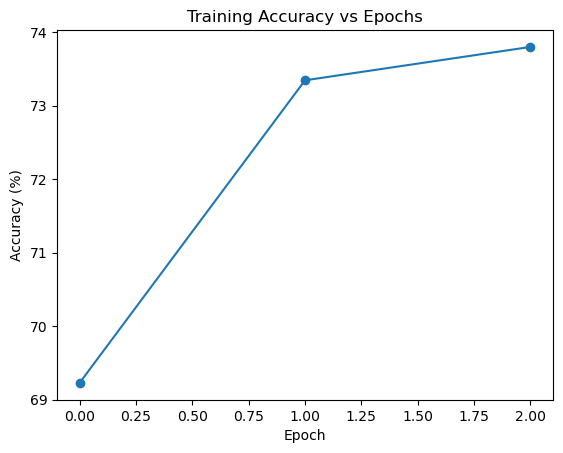

In [25]:
plt.plot(train_accuracy, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy vs Epochs")
plt.show()


In [26]:
torch.save(model.state_dict(), "resnet18_cifar10.pth")
